<a href="https://colab.research.google.com/github/tony3ynot/U-Net/blob/main/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Model Architecture

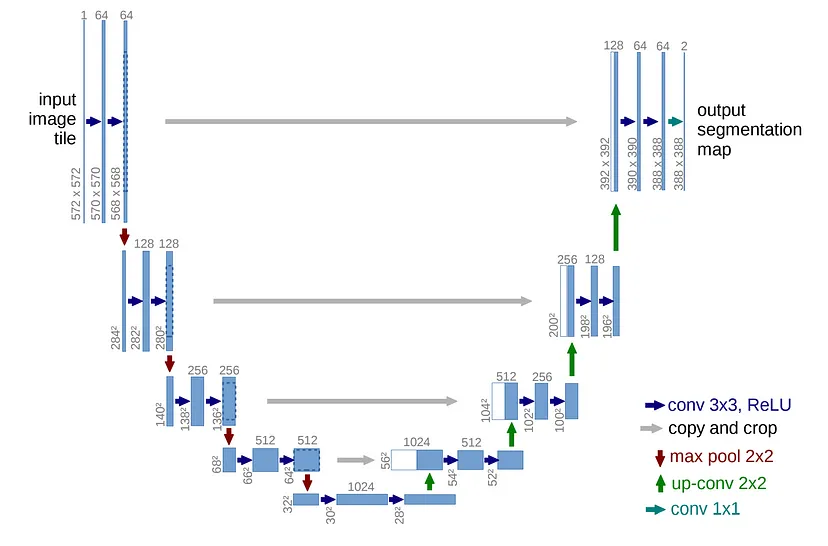

In [3]:
# (3x3 conv -> ReLU) x 2
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=2, features=[64, 128, 256, 512]):
        super().__init__()

        self.enc_layer = []
        self.dec_layer = []
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # down sampling (encoder)

        # contracting path (encoder)
        for feature in features:
            self.enc_layer.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # expanding path (decoder)
        for feature in reversed(features):
            self.dec_layer.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)) # up-sampling (decoder)
            self.dec_layer.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2) # connecting encoder & decoder
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1) # 1x1 mapping

    def forward(self, x):
        skip_connections = []
        # encoder
        for layer in self.enc_layer:
            x = layer(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        # decoder + skip connection
        for idx in range(0, len(self.dec_layer), 2):
            x = self.dec_layer[idx](x)
            skip_connection = skip_connections[idx//2]

            # image cropping for skip connection
            if x.shape != skip_connection.shape:
                skip_connection = TF.resize(skip_connection, size=x.shape[2:])

            x = torch.cat((skip_connection, x), dim=1) # concat
            x = self.dec_layer[idx+1](x)

        out = self.final_conv(x)
        return out

Check output size!

(572,572) -> (388, 388)

In [4]:
model = UNet()
!pip install torchinfo
from torchinfo import summary
summary(model, (2, 3, 572, 572), device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [2, 2, 388, 388]          --
├─MaxPool2d: 1-1                         [2, 64, 284, 284]         --
├─MaxPool2d: 1-2                         [2, 128, 140, 140]        --
├─MaxPool2d: 1-3                         [2, 256, 68, 68]          --
├─MaxPool2d: 1-4                         [2, 512, 32, 32]          --
├─DoubleConv: 1-5                        [2, 1024, 28, 28]         --
│    └─Sequential: 2-1                   [2, 1024, 28, 28]         --
│    │    └─Conv2d: 3-1                  [2, 1024, 30, 30]         4,718,592
│    │    └─BatchNorm2d: 3-2             [2, 1024, 30, 30]         2,048
│    │    └─ReLU: 3-3                    [2, 1024, 30, 30]         --
│    │    └─Conv2d: 3-4                  [2, 1024, 28, 28]         9,437,184
│    │    └─BatchNorm2d: 3-5             [2, 1024, 28, 28]         2,048
│    │    └─ReLU: 3-6                    [2, 1024, 28, 28]       